In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
import backtrader as bt
from datetime import datetime

In [2]:
#setting time-period
start = '2010-01-01'
end = '2023-02-24'
interval = "1d"

# Finding interesting assests

In [3]:
tickers = ["AAPL","TSLA","BTC-USD", "NFLX","ETH-USD", "AMZN", "NVDA", "SPY"]
df = yf.download(tickers, start = start, end = end, interval = interval)
df = df.interpolate().dropna()
close = df.loc[:,"Close"].copy()

[*********************100%***********************]  8 of 8 completed


In [4]:
ret = close.pct_change().dropna()
ret.shape

(1932, 8)

In [5]:
summ = ret.describe().T.loc[:,["mean","std"]]
summ["mean"] = summ["mean"]*len(ret)
summ["std"] = summ["std"]*np.sqrt(len(ret))
summ["returns/risk ratio"] = summ["mean"]/summ["std"]
summ.sort_values(by = ["returns/risk ratio"], ascending=False)

,mean,std,returns/risk ratio
TSLA,3.173607,1.319913,2.404406
AAPL,1.460291,0.688850,2.119897
NVDA,2.123713,1.091932,1.944913
ETH-USD,4.102235,2.203703,1.861519
BTC-USD,2.749208,1.739542,1.580421
SPY,0.538365,0.444358,1.211557
AMZN,0.815410,0.756505,1.077864
NFLX,1.046271,1.013461,1.032375


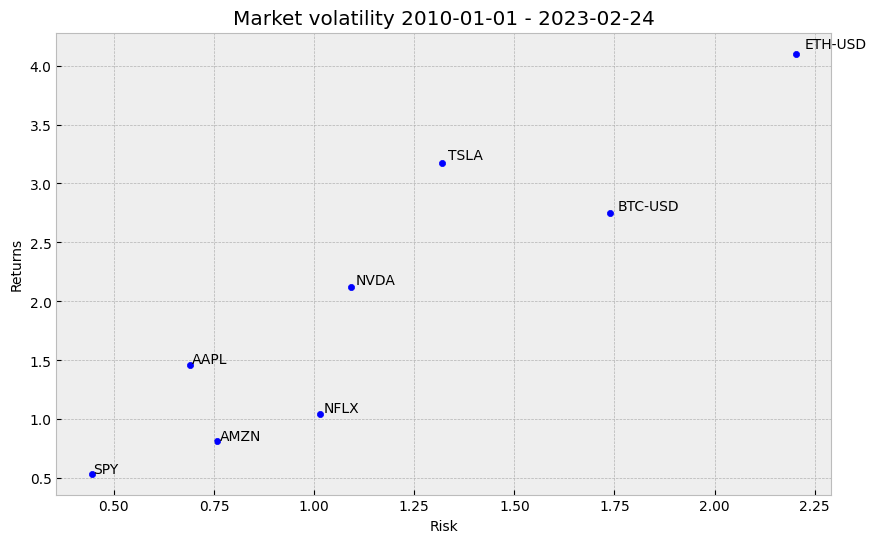

In [6]:
style.use('bmh')
summ.plot.scatter(x = "std", y = "mean", figsize = (10,6))
plt.xlabel("Risk")
plt.ylabel("Returns")
plt.title(f'Market volatility {start} - {end}')

for i in summ.index:
    plt.annotate(i, xy = (summ.loc[i,"std"]+0.01*summ.loc[i,"std"], summ.loc[i,"mean"]+0.01*summ.loc[i,"mean"])) 

In [7]:
colors = sns.color_palette("hls", 10)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Text(0.5, 0.98, 'Stock price trends 2010-01-01 - 2023-02-24')

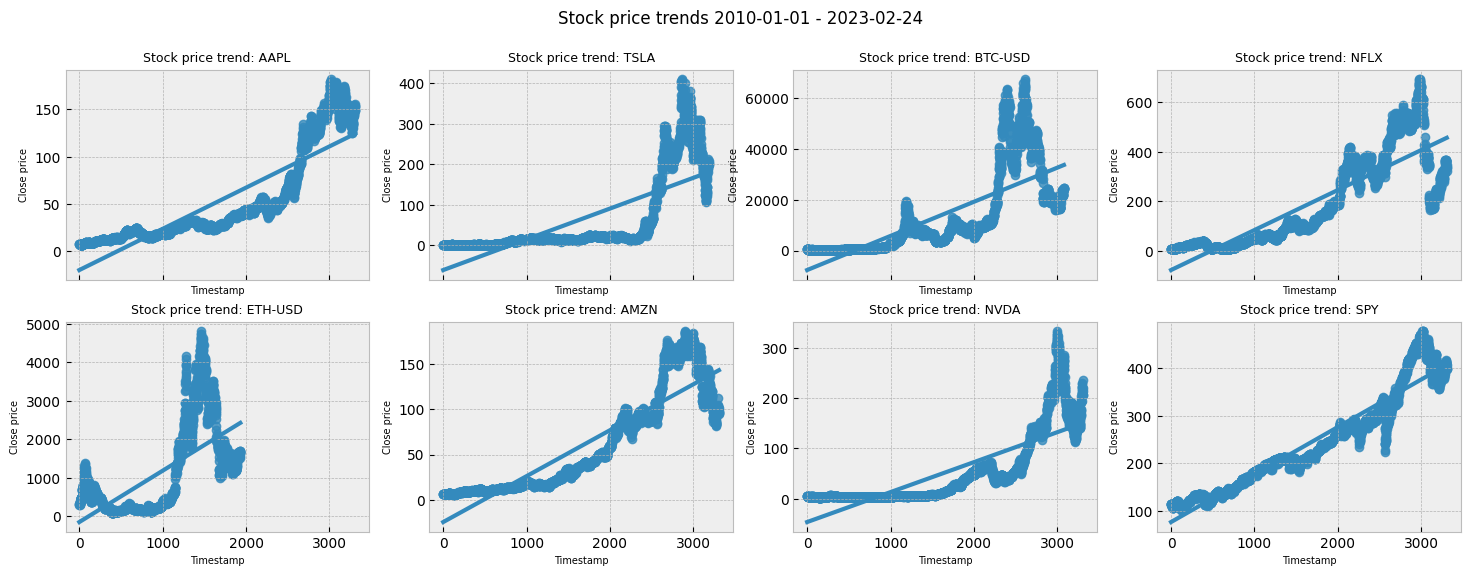

In [8]:
fig, axs = plt.subplots(2,4,figsize=(18,6), sharex = True)  

for ticker in tickers:
    if tickers.index(ticker) <= 3:
        i = 0
        m = 0
    else:
        i = 1
        m = 4
    df = yf.download(ticker, start = start, end = end, interval = interval)
    data = df.Close.to_frame().reset_index()
    sns.regplot(data = data, x=data.index, 
                y=data.Close, ci = None, 
                fit_reg = True, ax = axs[i,tickers.index(ticker)-m])
    axs[i,tickers.index(ticker)-m].set_title(f'Stock price trend: {ticker}', fontsize = 9)
    axs[i,tickers.index(ticker)-m].set_xlabel("Timestamp", fontsize = 7)
    axs[i,tickers.index(ticker)-m].set_ylabel("Close price", fontsize = 7)

#for ax in axs.flat:
#    ax.label_outer()

plt.suptitle(f'Stock price trends {start} - {end}')

## SMA strategy

In [9]:
def test_strategy(stock, start, end, interval, SMA, short):
    df = yf.download(stock, start=start, end=end, interval = interval)
    data = df.Close.to_frame()
    data["returns"] = np.log(data.Close.div(data.Close.shift(1)))
    data["SMA_S"] = data.Close.rolling(int(SMA[0])).mean()
    data["SMA_L"] = data.Close.rolling(int(SMA[1])).mean()
    data.dropna(inplace=True)
    
    data["position"] = np.where(data["SMA_S"]>data["SMA_L"],1,int(short))
    data["strategy"] = data["returns"]*data.position.shift(1)
    data.dropna(inplace=True)
    ret = np.exp(data["strategy"].sum())
    std = data["strategy"].std()*np.sqrt(len(data))
    
    return data, ret, std

In [25]:
#long-short
for ticker in tickers:
    print(f'{ticker}: {test_strategy(ticker, start = start, end = end, interval = interval, SMA = (20,100), short = -1)[1:]}')

[*********************100%***********************]  1 of 1 completed
AAPL: (2.206714690860643, 1.0225414785574114)
[*********************100%***********************]  1 of 1 completed
TSLA: (2.9633436424425685, 1.9849477118730838)
[*********************100%***********************]  1 of 1 completed
BTC-USD: (127.41704794595253, 2.107855763462755)
[*********************100%***********************]  1 of 1 completed
NFLX: (44.80962411499638, 1.8517590386409595)
[*********************100%***********************]  1 of 1 completed
ETH-USD: (7.411592480070262, 2.110305284796791)
[*********************100%***********************]  1 of 1 completed
AMZN: (1.981313994276038, 1.1818234532103777)
[*********************100%***********************]  1 of 1 completed
NVDA: (16.686159779185402, 1.5954497874554157)
[*********************100%***********************]  1 of 1 completed
SPY: (1.0347118346998532, 0.6315812278927599)


In [26]:
#long biased
for ticker in tickers:
    print(f'{ticker}: {test_strategy(ticker, start = start, end = end, interval = interval, SMA = (20,100), short = 0)[1:]}')

[*********************100%***********************]  1 of 1 completed
AAPL: (6.149426563941417, 0.8146419310676375)
[*********************100%***********************]  1 of 1 completed
TSLA: (17.452200137657684, 1.570479414689213)
[*********************100%***********************]  1 of 1 completed
BTC-USD: (98.29253591869136, 1.6631742954126068)
[*********************100%***********************]  1 of 1 completed
NFLX: (31.123743416626777, 1.358050686864582)
[*********************100%***********************]  1 of 1 completed
ETH-USD: (3.5914585949778597, 1.5877423502705528)
[*********************100%***********************]  1 of 1 completed
AMZN: (5.551326274591277, 0.8975415343924419)
[*********************100%***********************]  1 of 1 completed
NVDA: (35.19631371055237, 1.2193079279733572)
[*********************100%***********************]  1 of 1 completed
SPY: (1.9668040409071392, 0.42535533374895923)


In [27]:
#sma 9,25
for ticker in tickers:
    print(f'{ticker}: {test_strategy(ticker, start = start, end = end, interval = interval, SMA = (9,25), short = 0)[1:]}')

[*********************100%***********************]  1 of 1 completed
AAPL: (10.07488726101526, 0.7135044334830357)
[*********************100%***********************]  1 of 1 completed
TSLA: (116.4681799851711, 1.4563949506763014)
[*********************100%***********************]  1 of 1 completed
BTC-USD: (144.076186514038, 1.4785716739577857)
[*********************100%***********************]  1 of 1 completed
NFLX: (20.327693735127138, 1.3347552399120246)
[*********************100%***********************]  1 of 1 completed
ETH-USD: (24.49902167519296, 1.5940032804745066)
[*********************100%***********************]  1 of 1 completed
AMZN: (6.7470185278944435, 0.8404394360671816)
[*********************100%***********************]  1 of 1 completed
NVDA: (27.22968191922626, 1.1609667969816233)
[*********************100%***********************]  1 of 1 completed
SPY: (2.097435385745973, 0.3912057282543301)


## WVAP strategy

In [28]:
def test_strategy2(stock, start, end, interval, short):
    df = yf.download(stock, start=start, end=end, interval = interval)
    data = df[["Close","Volume"]].copy()
    data["VWAP"] = (data.Volume.values * data.Close.values).cumsum() / data.Volume.values.cumsum()
    data["returns"] = np.log(data.Close.div(data.Close.shift(1)))
    data.dropna(inplace=True)
    
    data["position"] = np.where(data["VWAP"]<data["Close"],1, int(short))
    data["strategy"] = data["returns"]*data.position.shift(1)
    data.dropna(inplace=True)
    ret = np.exp(data["strategy"].sum())
    std = data["strategy"].std()*np.sqrt(len(data))
    
    return data, ret, std

In [29]:
for ticker in tickers:
    print(f'{ticker}: {test_strategy2(ticker, start = start, end = end, interval = interval, short = -1)[1:]}')

[*********************100%***********************]  1 of 1 completed
AAPL: (16.981289012880723, 1.0406586591874605)
[*********************100%***********************]  1 of 1 completed
TSLA: (17.102949697094967, 2.0353455195494967)
[*********************100%***********************]  1 of 1 completed
BTC-USD: (30.82721574356919, 2.1343290383214772)
[*********************100%***********************]  1 of 1 completed
NFLX: (32.47149634378302, 1.8917607417185376)
[*********************100%***********************]  1 of 1 completed
ETH-USD: (19.60432602276123, 2.2341485722558754)
[*********************100%***********************]  1 of 1 completed
AMZN: (9.706740439126646, 1.1996982971932992)
[*********************100%***********************]  1 of 1 completed
NVDA: (63.43625280328629, 1.6179975526894104)
[*********************100%***********************]  1 of 1 completed
SPY: (2.067658689439581, 0.641960680500295)


In [30]:
for ticker in tickers:
    print(f'{ticker}: {test_strategy2(ticker, start = start, end = end, interval = interval, short = 0)[1:]}')

[*********************100%***********************]  1 of 1 completed
AAPL: (18.203189579363116, 1.0332692597716384)
[*********************100%***********************]  1 of 1 completed
TSLA: (46.641230094963504, 1.9753882051296319)
[*********************100%***********************]  1 of 1 completed
BTC-USD: (41.914718262892926, 1.6665569725467315)
[*********************100%***********************]  1 of 1 completed
NFLX: (37.79133281873576, 1.6146528656386432)
[*********************100%***********************]  1 of 1 completed
ETH-USD: (10.375430108913152, 1.5005956347874423)
[*********************100%***********************]  1 of 1 completed
AMZN: (11.752008975489977, 1.1797322694260983)
[*********************100%***********************]  1 of 1 completed
NVDA: (56.5752412217297, 1.4688465143850165)
[*********************100%***********************]  1 of 1 completed
SPY: (2.70010667633731, 0.6113894965834229)


## Testing diffrent strategies using Backtrader

## MACD strategy

In [38]:
class MacdStrategy(bt.Strategy):
    
    params = (
        ('macd1', 12),
        ('macd2', 26),
        ('macdsig', 9),
        ('atr_period', 14),
        ('risk_pct', 0.05)
    )
    
    def __init__(self):
        self.macd = bt.indicators.MACD(self.data.close, period_me1=self.params.macd1, period_me2=self.params.macd2, period_signal=self.params.macdsig)
        self.atr = bt.indicators.ATR(self.data, period=self.params.atr_period)
        self.stop_price = None
        self.position_size = None
        self.total_returns = 0
        
    def next(self):
        if self.position_size is not None:
            self.total_returns += self.position_size * (self.data.close[0] - self.data.close[-1]) / self.data.close[-1]
        
        if self.position:
            if self.position_size > 0:
                if self.macd.lines.macd[0] < self.macd.lines.signal[0]:
                    self.close()
                    self.position_size = None
                elif self.stop_price is not None and self.data.low[0] < self.stop_price:
                    self.close()
                    self.position_size = None
            elif self.position_size < 0:
                if self.macd.lines.macd[0] > self.macd.lines.signal[0]:
                    self.close()
                    self.position_size = None
                elif self.stop_price is not None and self.data.high[0] > self.stop_price:
                    self.close()
                    self.position_size = None
        else:
            if self.macd.lines.macd[0] > self.macd.lines.signal[0] and self.macd.lines.macd[-1] < self.macd.lines.signal[-1]:
                self.buy()
                self.position_size = int(self.broker.cash * self.params.risk_pct / self.atr[0])
                self.stop_price = self.data.close[0] - 2 * self.atr[0]
            elif self.macd.lines.macd[0] < self.macd.lines.signal[0] and self.macd.lines.macd[-1] > self.macd.lines.signal[-1]:
                self.sell()
                self.position_size = int(self.broker.cash * self.params.risk_pct / self.atr[0])
                self.stop_price = self.data.close[0] + 2 * self.atr[0]


In [49]:
for ticker in tickers:
    cerebro = bt.Cerebro()
    tsla = yf.download(ticker, start=start, end=end)
    data = bt.feeds.PandasData(dataname=tsla)
    cerebro.adddata(data)
    cerebro.addstrategy(MacdStrategy)
    
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='mysharpe')
    cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='profitfactor')
    
    results = cerebro.run()
    
    print(ticker)
    print('Total Returns:', results[0].analyzers.returns.get_analysis()['rtot'])
    print('Sharpe Ratio:', results[0].analyzers.mysharpe.get_analysis()['sharperatio'])

[*********************100%***********************]  1 of 1 completed
AAPL
Total Returns: 0.013216245924373433
Sharpe Ratio: -6.786625970741716
[*********************100%***********************]  1 of 1 completed
TSLA
Total Returns: 0.01084063256660971
Sharpe Ratio: -1.499509791449231
[*********************100%***********************]  1 of 1 completed
BTC-USD
Total Returns: 1.672431075272056
Sharpe Ratio: 0.530758129944168
[*********************100%***********************]  1 of 1 completed
NFLX
Total Returns: 0.01889785591227523
Sharpe Ratio: -1.583813872786722
[*********************100%***********************]  1 of 1 completed
ETH-USD
Total Returns: 0.18190031469752543
Sharpe Ratio: 0.3703441611399629
[*********************100%***********************]  1 of 1 completed
AMZN
Total Returns: 0.006318693520896667
Sharpe Ratio: -10.789138290272593
[*********************100%***********************]  1 of 1 completed
NVDA
Total Returns: 0.009710943380555555
Sharpe Ratio: -1.541088332603908

## MA/RSI Trading Strategy

In [48]:
class MaRsiStrategy(bt.Strategy):
    
    def __init__(self):
        self.short_ma = bt.indicators.SMA(self.data.close, period=9)
        self.long_ma = bt.indicators.SMA(self.data.close, period=25)
        self.rsi = bt.indicators.RSI(self.data.close, period=14)
        self.position_size = 0
        self.total_returns = 0
        
    def next(self):
        if self.position_size is not None:
            self.total_returns += self.position_size * (self.data.close[0] - self.data.close[-1]) / self.data.close[-1]
        if self.position:
            if self.position_size > 0:
                if self.rsi > 50 or self.long_ma[0] > self.short_ma[0]:
                    self.sell()
                    self.position_size = None
            elif self.position_size < 0:
                if self.rsi < 50 or self.long_ma[0] < self.short_ma[0]:
                    self.buy()
                    self.position_size = None
        else:
            if self.short_ma[0] > self.long_ma[0] and self.rsi < 30:
                self.buy()
                self.position_size = 1
            elif self.short_ma[0] < self.long_ma[0] and self.rsi > 70:
                self.sell()
                self.position_size = -1
            elif self.short_ma[0] < self.long_ma[0] and self.rsi < 30:
                self.sell()
                self.position_size = -1
            elif self.short_ma[0] > self.long_ma[0] and self.rsi > 70:
                self.buy()
                self.position_size = 1


In [47]:
for ticker in tickers:
    cerebro = bt.Cerebro()
    tsla = yf.download(ticker, start=start, end=end)
    data = bt.feeds.PandasData(dataname=tsla)
    cerebro.adddata(data)
    cerebro.addstrategy(MaRsiStrategy)
    
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='mysharpe')
    cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='profitfactor')
    
    results = cerebro.run()
    
    print(ticker)
    print('Total Returns:', results[0].analyzers.returns.get_analysis()['rtot'])
    print('Sharpe Ratio:', results[0].analyzers.mysharpe.get_analysis()['sharperatio'])

[*********************100%***********************]  1 of 1 completed
AAPL
Total Returns: -0.0010799082809679
Sharpe Ratio: -16.459961352245642
[*********************100%***********************]  1 of 1 completed
TSLA
Total Returns: 0.003907288169315309
Sharpe Ratio: -3.4298182708394997
[*********************100%***********************]  1 of 1 completed
BTC-USD
Total Returns: 0.1644967453554111
Sharpe Ratio: 0.13123225234155103
[*********************100%***********************]  1 of 1 completed
NFLX
Total Returns: 0.018804107881209578
Sharpe Ratio: -3.4455264767919536
[*********************100%***********************]  1 of 1 completed
ETH-USD
Total Returns: 0.17222674854479486
Sharpe Ratio: 0.5073958376711427
[*********************100%***********************]  1 of 1 completed
AMZN
Total Returns: -0.0002388276598928306
Sharpe Ratio: -28.865320160280724
[*********************100%***********************]  1 of 1 completed
NVDA
Total Returns: 0.010804178255568866
Sharpe Ratio: -2.791386

## MACD/RSI Strategy

In [72]:
class MacdRsiStrategy(bt.Strategy):
    
    params = (
        ('fast', 12),
        ('slow', 26),
        ('signal', 9),
        ('rsi_period', 14),
        ('rsi_upper', 70),
        ('rsi_lower', 30),
    )
    
    def __init__(self):
        self.macd = bt.indicators.MACD(self.data.close, period_me1=self.params.fast,
                                       period_me2=self.params.slow, period_signal=self.params.signal)
        self.rsi = bt.indicators.RSI(self.data.close, period=self.params.rsi_period)
        self.position_size = None
        self.total_returns = 0
        
    def next(self):
        if self.position_size is not None:
            self.total_returns += self.position_size * (self.data.close[0] - self.data.close[-1]) / self.data.close[-1]
        if self.position:
            if self.position_size > 0:
                if self.macd.lines.macd[0] < self.macd.lines.signal[0]:
                    self.sell()
                    self.position_size = None
            elif self.position_size < 0:
                if self.macd.lines.macd[0] > self.macd.lines.signal[0]:
                    self.buy()
                    self.position_size = None
        else:
            if self.macd.lines.macd[0] > self.macd.lines.signal[0] and self.rsi < self.params.rsi_lower:
                self.buy()
                self.position_size = 1
            elif self.macd.lines.macd[0] < self.macd.lines.signal[0] and self.rsi > self.params.rsi_upper:
                self.sell()
                self.position_size = -1

In [73]:
for ticker in tickers:
    cerebro = bt.Cerebro()
    tsla = yf.download(ticker, start=start, end=end)
    data = bt.feeds.PandasData(dataname=tsla)
    cerebro.adddata(data)
    cerebro.addstrategy(MacdRsiStrategy)
    
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='mysharpe')
    cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='profitfactor')
    
    results = cerebro.run()
    
    print(ticker)
    print('Total Returns:', results[0].analyzers.returns.get_analysis()['rtot'])
    print('Sharpe Ratio:', results[0].analyzers.mysharpe.get_analysis()['sharperatio'])

[*********************100%***********************]  1 of 1 completed
AAPL
Total Returns: 0.0013898547796667262
Sharpe Ratio: -24.73798011925369
[*********************100%***********************]  1 of 1 completed
TSLA
Total Returns: 0.006334694945422316
Sharpe Ratio: -5.6197131734816645
[*********************100%***********************]  1 of 1 completed
BTC-USD
Total Returns: -0.3453099094130836
Sharpe Ratio: -0.8339556932257282
[*********************100%***********************]  1 of 1 completed
NFLX
Total Returns: 0.0007899762395547269
Sharpe Ratio: -9.618481502712536
[*********************100%***********************]  1 of 1 completed
ETH-USD
Total Returns: 0.001394946409505401
Sharpe Ratio: -0.6065957669901225
[*********************100%***********************]  1 of 1 completed
AMZN
Total Returns: -0.0005504014965233834
Sharpe Ratio: -95.98607459548045
[*********************100%***********************]  1 of 1 completed
NVDA
Total Returns: -0.000900155083855589
Sharpe Ratio: -67.0